In [24]:
import sys,os, re, csv, codecs
import numpy as np
import pandas as pd
import keras
import tensorflow
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers,layers
from keras.callbacks import TensorBoard
from time import time
%matplotlib inline

In [7]:
train_file= 'train.csv'
test_file= 'test.csv'
test_label_file = 'test_labels.csv'
embedding_file = 'glove6b200d/glove6b200d.txt'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [4]:
embed_size = 200
max_features = 200000
maxlen = 100


list_sentences_train = train["comment_text"].fillna("_na_").values
list_sentences_test = test["comment_text"].fillna("_na_").values

list_classes = ["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_t = train[list_classes].values

In [5]:
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 210337 unique tokens.


In [9]:
embeddings_index={}

f = open(embedding_file, encoding = "utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 400000 word vectors.


In [10]:
all_embeddings = np.stack(embeddings_index.values())

emb_mean= all_embeddings.mean()
emb_stddev = all_embeddings.std()

In [11]:
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_stddev, (nb_words, embed_size))
for word, i in word_index.items():
    if i>=max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [19]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
history = model.fit(X_t, y_t, batch_size=32, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 2713s 19ms/step - loss: 0.0556 - acc: 0.9803 - val_loss: 0.0466 - val_acc: 0.9827
Epoch 2/2
143613/143613 [==============================] - 2750s 19ms/step - loss: 0.0384 - acc: 0.9850 - val_loss: 0.0455 - val_acc: 0.9834


In [48]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


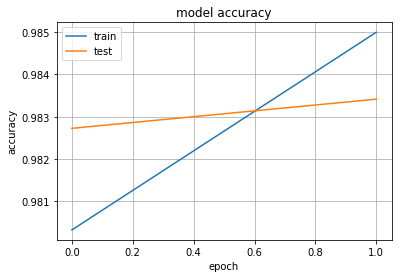

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

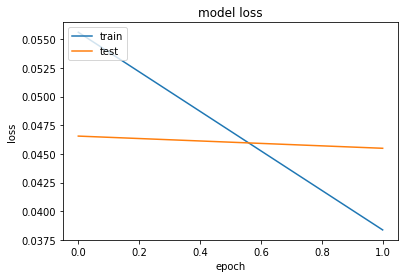

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [33]:
train_file_en= 'train.csv'
train_file_de = 'train_de.csv'
train_file_fr = 'train_fr.csv'
train_file_es = 'train_es.csv'
test_file= 'test.csv'
test_label_file = 'test_labels.csv'
embedding_file = 'glove6b200d/glove6b200d.txt'

train_en = pd.read_csv(train_file_en)
train_es = pd.read_csv(train_file_es)
train_fr = pd.read_csv(train_file_fr)
train_de = pd.read_csv(train_file_de)

test = pd.read_csv(test_file)

In [46]:
train1 = train_en.append(train_es.append(train_de.append(train_fr, ignore_index= True), ignore_index=True), ignore_index=True)

In [40]:
train = train.append(train_fr, ignore_index=True)

In [42]:
train = train.append(train_de, ignore_index=True)

In [47]:
train1.shape

(638284, 8)

In [51]:
y_test = model.predict([X_te], batch_size = 1024, verbose = 1)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv',index=False)

153164/153164 [==============================] - 108s 705us/step


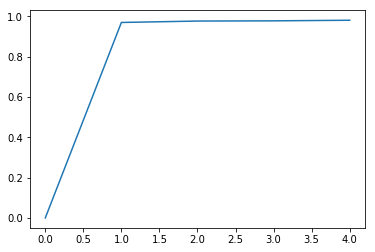